# Plots

The idea here is to put down a vector field $u^a$ and construct time averages and space filterings.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp, quad
from scipy.optimize import minimize

In [2]:
%matplotlib inline

In [3]:
from mpl_toolkits.mplot3d import proj3d

def make_get_proj(self, rx, ry, rz):
    '''
    Return a variation on :func:`~mpl_toolkit.mplot2d.axes3d.Axes3D.getproj` that
    makes the box aspect ratio equal to *rx:ry:rz*, using an axes object *self*.
    '''

    rm = max(rx, ry, rz)
    kx = rm / rx; ky = rm / ry; kz = rm / rz;

    # Copied directly from mpl_toolkit/mplot3d/axes3d.py. New or modified lines are
    # marked by ##
    def get_proj():
        relev, razim = np.pi * self.elev/180, np.pi * self.azim/180

        xmin, xmax = self.get_xlim3d()
        ymin, ymax = self.get_ylim3d()
        zmin, zmax = self.get_zlim3d()

        # transform to uniform world coordinates 0-1.0,0-1.0,0-1.0
        worldM = proj3d.world_transformation(xmin, xmax,
                                             ymin, ymax,
                                             zmin, zmax)

        # adjust the aspect ratio                          ##
        aspectM = proj3d.world_transformation(-kx + 1, kx, ##
                                              -ky + 1, ky, ##
                                              -kz + 1, kz) ##

        # look into the middle of the new coordinates
        R = np.array([0.5, 0.5, 0.5])

        xp = R[0] + np.cos(razim) * np.cos(relev) * self.dist
        yp = R[1] + np.sin(razim) * np.cos(relev) * self.dist
        zp = R[2] + np.sin(relev) * self.dist
        E = np.array((xp, yp, zp))

        self.eye = E
        self.vvec = R - E
        self.vvec = self.vvec / proj3d.mod(self.vvec)

        if abs(relev) > np.pi/2:
            # upside down
            V = np.array((0, 0, -1))
        else:
            V = np.array((0, 0, 1))
        zfront, zback = -self.dist, self.dist

        viewM = proj3d.view_transformation(E, R, V)
        perspM = proj3d.persp_transformation(zfront, zback)
        M0 = np.dot(viewM, np.dot(aspectM, worldM)) ##
        M = np.dot(perspM, M0)
        return M
    return get_proj

In [4]:
np.random.seed(1234)

In [5]:
a_s = np.random.rand(50)
b_s = np.random.rand(50)
c_s = np.random.rand(50)
d_s = np.random.rand(50)
e_s = np.random.rand(50)
f_s = np.random.rand(50)
g_s = np.random.rand(50)
h_s = np.random.rand(50)

In [6]:
def v_s(t, x, y):
    v = np.zeros((2,))
    for n, (a, b, c, d, e, f, g) in enumerate(zip(a_s, b_s, c_s, d_s, e_s, f_s, g_s)):
        v_mag = 0.5 * np.exp(-(n-15)**2/50) * np.sin(a * n * x + b) * np.sin(e * n * y + f) * np.cos(c * n * t + d)**2
        v_angle = 2 * np.pi * g
        v[0] += v_mag * np.cos(v_angle) 
        v[1] += v_mag * np.sin(v_angle) 
    return v

In [25]:
def v_s(t, x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(x - 0.02 * np.sin(20*t), y + 0.01 * np.sin(25*t))
    v_theta = 0.4 + 0.5 * np.cos(10*t)**2
    v_x = -v_theta * y
    v_y =  v_theta * x
    v = np.array([v_x, v_y])
    for n, (a, b, c, d, e, f, g) in enumerate(zip(a_s, b_s, c_s, d_s, e_s, f_s, g_s)):
        v_mag = 0.1 * np.exp(-(n-15)**2/50) * np.sin(a * n * x + b) * np.sin(e * n * y + f) * np.cos(c * n * t + d)**2
        v_angle = 2 * np.pi * g
        v[0] += v_mag * np.cos(v_angle) 
        v[1] += v_mag * np.sin(v_angle) 
    return v

In [26]:
def streamline_rhs(tau, q):
    t, x, y = q
    vx, vy = v_s(t, x, y)
    W = 1 / np.sqrt(1 - vx*vx - vy*vy)
    ut = W
    ux = W * vx
    uy = W * vy
    dqdtau = np.array([ut, ux, uy])
    return dqdtau

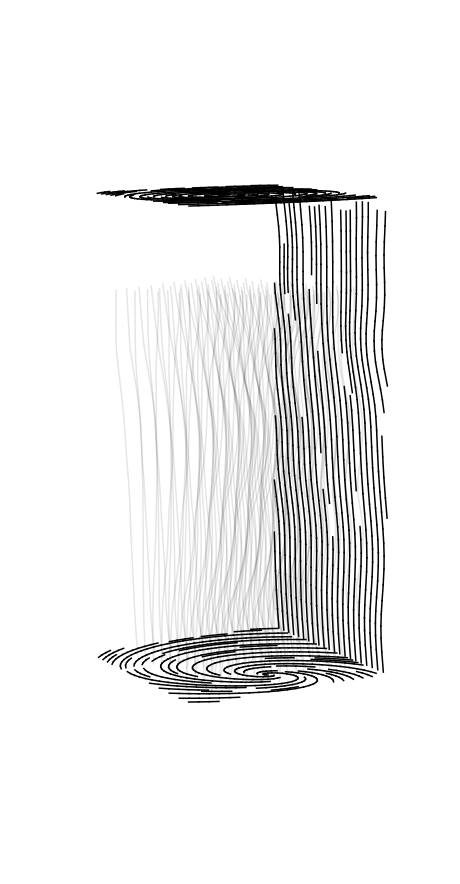

In [27]:
nx = 10
t0s = np.zeros(nx**2)
x0s_1d = np.linspace(-0.05, 0.05, nx)
y0s_1d = np.linspace(-0.05, 0.05, nx)
x0s, y0s = np.meshgrid(x0s_1d, x0s_1d)
x0s = x0s.flatten()
y0s = y0s.flatten()
fig = plt.figure(figsize=(8, 16))
ax = fig.add_subplot(111, projection='3d')
taus = np.linspace(0, 0.8, 500)
minmax = [[np.inf, -np.inf], [np.inf, -np.inf]]
for i, (t0, x0, y0) in enumerate(zip(t0s, x0s, y0s)):
    soln = solve_ivp(streamline_rhs, [0, 1], [t0, x0, y0], dense_output=True)
    q = soln.sol(taus)
    for d in range(2):
        minmax[d][0] = min(minmax[d][0], np.min(q[d+1]))
        minmax[d][1] = max(minmax[d][1], np.max(q[d+1]))
    ax.plot(q[1], q[2], q[0], ls='-', color='black', alpha=0.1)

# ax.get_proj = make_get_proj(ax, 1, 1, 1)
# ax.set_aspect(1.0)
ax.axis('off')

taus = [0, 1.0]
for tau in taus:
    fig_tmp, ax_tmp = plt.subplots()
    X, Y = np.mgrid[minmax[0][0]:minmax[0][1]:20j, minmax[1][0]:minmax[1][1]:20j]
    X, Y = np.meshgrid(np.linspace(minmax[0][0], minmax[0][1], 20),
                       np.linspace(minmax[1][0], minmax[1][1], 20))
    vx = np.zeros_like(Y)
    vy = np.zeros_like(Y)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            vx[i, j], vy[i, j] = v_s(tau, X[i, j], Y[i, j])
#     res = ax_tmp.streamplot(X.T, Y.T, vx, vy, color='k', density=[0.8, 0.8])
    res = ax_tmp.streamplot(X, Y, vx, vy, color='k', density=[0.8, 0.8])
    plt.close(fig_tmp)
    # extract the lines from the temporary figure
    lines = res.lines.get_paths()
    for line in lines:
        old_x = line.vertices.T[0]
        old_y = line.vertices.T[1]
        # apply for 2d to 3d transformation here
        new_z = tau * np.ones_like(old_x)
        new_x = old_x
        new_y = old_y
        ax.plot(new_x, new_y, new_z, 'k')

Y = minmax[1][1]
X, taus = np.mgrid[minmax[0][0]:minmax[0][1]:20j, 0:1:20j]
X, taus = np.meshgrid(np.linspace(minmax[0][0], minmax[0][1], 20),
                      np.linspace(0, 1, 20))
vx = np.zeros_like(X)
vy = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        vx[i, j], vy[i, j] = v_s(taus[i,j], X[i, j], Y)
W = 1/np.sqrt(1 - vx**2 - vy**2)
# res = ax_tmp.streamplot(X.T, taus.T, W * vx, W, color='k', density=[0.8, 0.8])
res = ax_tmp.streamplot(X, taus, W * vx, W, color='k', density=[0.8, 0.8])
plt.close(fig_tmp)
# extract the lines from the temporary figure
lines = res.lines.get_paths()
for line in lines:
    old_x = line.vertices.T[0]
    old_z = line.vertices.T[1]
    # apply for 2d to 3d transformation here
    new_y = Y * np.ones_like(old_x)
    new_x = old_x
    new_z = old_z
    ax.plot(new_x, new_y, new_z, 'k')
    
ax.view_init(5, -30)
plt.show()

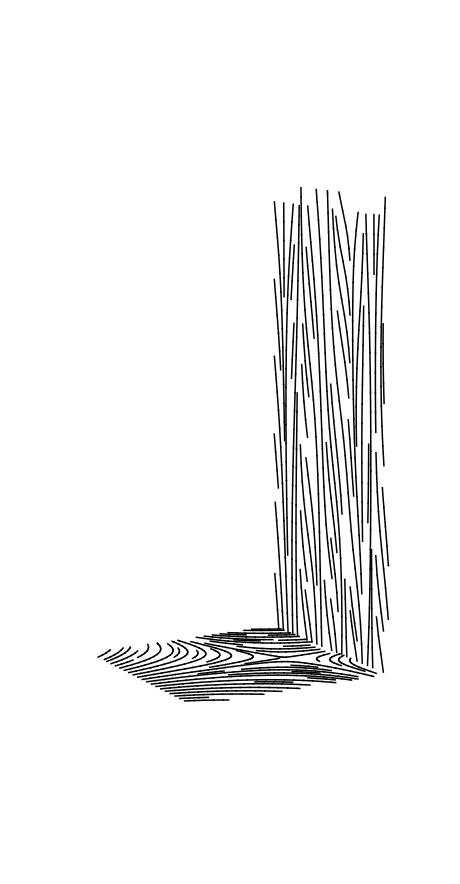

In [28]:
fig = plt.figure(figsize=(8, 16))
ax = fig.add_subplot(111, projection='3d')
ax.axis('off')

tau = 0
fig_tmp, ax_tmp = plt.subplots()
X, Y = np.mgrid[minmax[0][0]:minmax[0][1]:200j, minmax[1][0]:minmax[1][1]:200j]
vx = np.zeros_like(Y)
vy = np.zeros_like(Y)
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        vx[i, j], vy[i, j] = v_s(tau, X[i, j], Y[i, j])
res = ax_tmp.streamplot(X.T, Y.T, vx, vy, color='k', density=[0.8, 0.8])
plt.close(fig_tmp)
# extract the lines from the temporary figure
lines = res.lines.get_paths()
for line in lines:
    old_x = line.vertices.T[0]
    old_y = line.vertices.T[1]
    # apply for 2d to 3d transformation here
    new_z = tau * np.ones_like(old_x)
    new_x = old_x
    new_y = old_y
    ax.plot(new_x, new_y, new_z, 'k')
    
Y = minmax[1][1]
X, taus = np.mgrid[minmax[0][0]:minmax[0][1]:200j, 0:1:200j]
vx = np.zeros_like(X)
vy = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        vx[i, j], vy[i, j] = v_s(taus[i,j], X[i, j], Y)
W = 1/np.sqrt(1 - vx**2 - vy**2)
res = ax_tmp.streamplot(X.T, taus.T, W * vx, W, color='k', density=[0.8, 0.8])
plt.close(fig_tmp)
# extract the lines from the temporary figure
lines = res.lines.get_paths()
for line in lines:
    old_x = line.vertices.T[0]
    old_z = line.vertices.T[1]
    # apply for 2d to 3d transformation here
    new_y = Y * np.ones_like(old_x)
    new_x = old_x
    new_z = old_z
    ax.plot(new_x, new_y, new_z, 'k')
    
ax.view_init(5, -30)
plt.show()

In [29]:
def getU(Vmag, Vangle):
    Vx = Vmag * np.cos(Vangle)
    Vy = Vmag * np.sin(Vangle)
    WW = 1 / np.sqrt(1 - Vx*Vx - Vy*Vy)
    return WW, WW * Vx, WW * Vy

def Udotu(Vmag, Vangle, t, x, y):
    # Micro value
    vx, vy = v_s(t, x, y)
    W = 1 / np.sqrt(1 - vx*vx - vy*vy)
    ut = W
    ux = W * vx
    uy = W * vy
    # Macro value
    Ut, Ux, Uy = getU(Vmag, Vangle)
#     print(t, x, y, vx, vy, ut, ux, uy, Ut, Ux, Uy)
    # Dot
    return -ut * Ut + ux * Ux + uy * Uy

def get_line(t0, x0, y0, tau, Vmag, Vangle):
    Ut, Ux, Uy = getU(Vmag, Vangle)
    t = t0 + tau * Ut
    x = x0 + tau * Ux
    y = y0 + tau * Uy
    return t, x, y

In [30]:
T = 1

def f_to_quad(tau, t0, x0, y0, Vmag, Vangle):
    t, x, y = get_line(t0, x0, y0, tau, Vmag, Vangle)
    integrand = (1 - Udotu(Vmag, Vangle, t, x, y)**2)**2
#     print(integrand, Vmag, Vangle)
    return integrand

def f_to_min(p, t0, x0, y0):
    Vmag, Vangle = p
    total, err = quad(f_to_quad, 0, T, args=(t0, x0, y0, Vmag, Vangle))
    return total / T

In [31]:
t0 = 0
x0 = 0.0
y0 = 0.0
p0 = [t0, x0, y0]
soln_average_0 = minimize(f_to_min, (0.1, -1), bounds=((0, 0.9), (-1.5*np.pi, 1.5*np.pi)),
                          args=(t0, x0, y0), method='TNC')

In [32]:
soln_average_0

     fun: 3.726532435109926e-07
     jac: array([-1.05966633e-07,  9.71125762e-08])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 23
     nit: 4
  status: 1
 success: True
       x: array([ 0.00763401, -0.92048462])

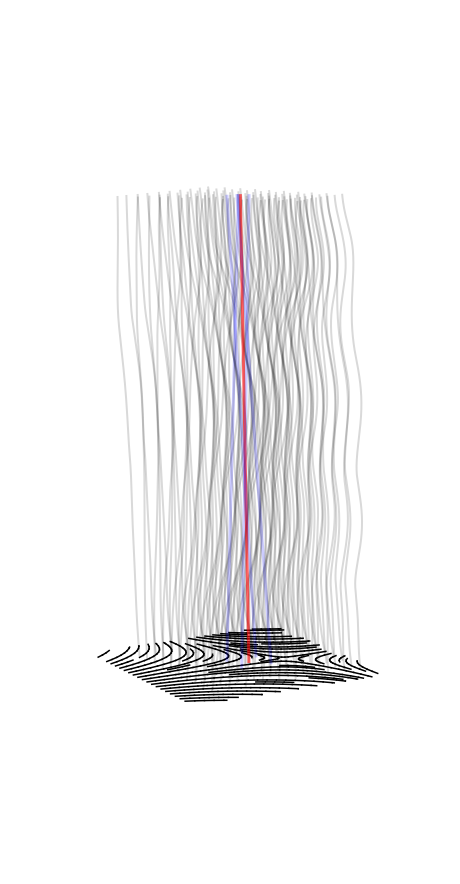

In [39]:
nx = 10
t0s = np.zeros(nx**2)
x0s_1d = np.linspace(-0.05, 0.05, nx)
y0s_1d = np.linspace(-0.05, 0.05, nx)
x0s, y0s = np.meshgrid(x0s_1d, x0s_1d)
x0s = x0s.flatten()
y0s = y0s.flatten()
fig = plt.figure(figsize=(8, 16))
ax = fig.add_subplot(111, projection='3d')
taus = np.linspace(0, 0.9, 500)
minmax = [[np.inf, -np.inf], [np.inf, -np.inf]]
for i, (t0, x0, y0) in enumerate(zip(t0s, x0s, y0s)):
    soln = solve_ivp(streamline_rhs, [0, 1], [t0, x0, y0], dense_output=True)
    q = soln.sol(taus)
    for d in range(2):
        minmax[d][0] = min(minmax[d][0], np.min(q[d+1]))
        minmax[d][1] = max(minmax[d][1], np.max(q[d+1]))
    ax.plot(q[1], q[2], q[0], ls='-', lw=2, color='black', alpha=0.15)

# ax.get_proj = make_get_proj(ax, 1, 1, 1)
# ax.set_aspect(1.0)
ax.axis('off')

taus = [0] # [0, 1.0]
for tau in taus:
    fig_tmp, ax_tmp = plt.subplots()
    X, Y = np.mgrid[minmax[0][0]:minmax[0][1]:100j, minmax[1][0]:minmax[1][1]:100j]
    vx = np.zeros_like(Y)
    vy = np.zeros_like(Y)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            vx[i, j], vy[i, j] = v_s(tau, X[i, j], Y[i, j])
    res = ax_tmp.streamplot(X.T, Y.T, vx, vy, color='k', density=[0.8, 0.8])
    plt.close(fig_tmp)
    # extract the lines from the temporary figure
    lines = res.lines.get_paths()
    for line in lines:
        old_x = line.vertices.T[0]
        old_y = line.vertices.T[1]
        # apply for 2d to 3d transformation here
        new_z = tau * np.ones_like(old_x)
        new_x = old_x
        new_y = old_y
        ax.plot(new_x, new_y, new_z, 'k')

# Y = minmax[1][1]
# X, taus = np.mgrid[minmax[0][0]:minmax[0][1]:100j, 0:1:100j]
# vx = np.zeros_like(X)
# vy = np.zeros_like(X)
# for i in range(X.shape[0]):
#     for j in range(X.shape[1]):
#         vx[i, j], vy[i, j] = v_s(taus[i,j], X[i, j], Y)
# W = 1/np.sqrt(1 - vx**2 - vy**2)
# res = ax_tmp.streamplot(X.T, taus.T, W * vx, W, color='k', density=[0.8, 0.8])
# plt.close(fig_tmp)
# # extract the lines from the temporary figure
# lines = res.lines.get_paths()
# for line in lines:
#     old_x = line.vertices.T[0]
#     old_z = line.vertices.T[1]
#     # apply for 2d to 3d transformation here
#     new_y = Y * np.ones_like(old_x)
#     new_x = old_x
#     new_z = old_z
#     ax.plot(new_x, new_y, new_z, 'k')
    
ax.view_init(5, -30)

# p0s = [[0,  0.03,  0.03],
#        [0, -0.03,  0.03],
#        [0,  0.03, -0.03],
#        [0, -0.03, -0.03]]
# p0s = [[0.0, 0.0, 0.0]]
p0s = [[0.0,  0.0,  0.0],
       [0.0,  0.01,  0.01],
       [0.0, -0.01,  0.01],
       [0.0,  0.01, -0.01],
       [0.0, -0.01, -0.01]]
colors = ['red', 'blue', 'blue', 'blue', 'blue']
alphas = [0.6, 0.2, 0.2, 0.2, 0.2]
for p0, color, alpha in zip(p0s, colors, alphas):
    t0, x0, y0 = p0
    soln_average_0 = minimize(f_to_min, (0.1, -2), bounds=((0, 0.9), (-1.5*np.pi, 1.5*np.pi)),
                              args=(t0, x0, y0), method='TNC')
    Ut, Ux, Uy = getU(*soln_average_0.x)
    ax.plot([x0, 0.9*Ux], [y0, 0.9*Uy], [t0, 0.9*Ut], ls='-', lw=3, color=color, alpha=alpha)
    
fig.savefig('time_average1.png', bbox_inches='tight', dpi=300)
plt.show()